# Leveraging Location Data to Predict COVID19 Hotspots in Neighbourhoods¶

 Problem Introduction

The COVID-19 pandemic precipitated in the end of 2019, where a then unknown
SARS-like virus started spreading through the global population. The pandemic
has caused widespread nation-wide lockdowns beginning in early 2020 and its
effects are still in play some 2 years later. Much research has been conducted
in an attempt to slow the spread of the virus; these included

1. Wearing Face masks
2. Social Distancing
3. Working from Home

It is thus of interest for public health officials to model possible hotspots
based on venues that require unmasking and close physical contact. Thus, this
project aims to develop a hotspot map of a neighbourhood based on the existing
businesses that provide services which violate the above list of recommended
safety measures.


Data Collection

The neighbourhood in question is ultimately arbitrary; but the location data
used will be from the FourSquare API. Businessess will be ranked based on:
1. If the service(s) provided requires unmasking
2. The duration of which customers are present for
3. The possiblity of social distancing

Upon this three risk factors, a data set of types of business will be given
points, one for each risk factor that they fall under. For example: a barbershop
requires the stylist to be in close proximity to the client for an extended time
and the client has to be unmasked for an extended period of time. Thus the
barbershop will be given 3 points. On the other hand, a Retail shop requires
only for the customers to be in close proximity to each other for a short period
of time and thus will be given 1 point.

Modelling

The neighbourhood will be clustered using K-means clustering to determine
centroids of businesses within a particular neighbourhood. Each centroid will
then be ranked based on how many risk points all of the businesses in its vicinity
and then plotted on a map to provide possible hostpots for local health officials
to continually monitor.

Data Analysis

The data for the businesses around the area was obtained from the FourSquare
API. The chosen location is Christchurch in New Zealand. In total there was
more than 80 businesses in the vicinity.

K Means Clustering

The K means clustering was done on the latitiude and longitude of data set.
The cluster number of 3 was obtained as based on visual inspection, made the
most sense in the context of this project. The data was plotted against the map
of the City.

Caveats of the model

There are apparent caveats of the model, in that it favours locations with localised high density of businesess. It would be different if it were in a different
borough where the density of businesses was more spread out. Furthermore,
there was not enough data for less populated areas such as the suburbs thus,
the data may not reflect reality.

Discussion

Based on the results of the K-means clustering; we can see that there are 3 distict
clusters where there are areas of higher traffic, thus, we can assume that the
spread will be more concentrated in those regions and the regions surrounding
it. In relation to the problem situation, we can thus take a more measured
approach when dealing with traffic in these regions. For example, authorities
may perhaps consider banning certain high-risk high exposure activities such as
exercise, and other activities that are done for prolonged durations an requires
unmasking.

Conclusion

In conclusion, the data reflected 3 possible clusters where there might be a high
occurrence of COVID-19 due to the high risk activities in those locations. The
model can be expanded to include a more detailed analysis of the frequency of
visitors and the population density of the area. A coupled differential equation of
modelling the spread of the may be implemented in tandem with this clustering
model in order to provide a greater insight of the spread of the virus. This can
allow officials to take a data based apporach in legislating changes in the fight
against the pandemic.

In [1]:
!pip install -U numpy

!pip install -U pandas

!pip install -U scipy

!pip install -U scikit-learn

!pip install -U imbalanced-learn
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import matplotlib.pyplot as plt

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.52         |     pyhd8ed1ab_0          35 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          99 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.52-pyhd8ed1ab_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0



geopy-2.1.0          | 64 KB     | ##################################### | 100% 
geographiclib-1.52   | 35 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transacti

In [2]:
#Using FourSquare API

CLIENT_ID = '1MUOL3FQPW1GTJFUGKOZMMAO5VOJ5TNVB4MHUGEPOQL4HCW0' # your Foursquare ID
CLIENT_SECRET = 'BKIITPAK33YA32UYDLDVNZICCZWA1ORYB5IBTKLB0130RID2' # your Foursquare Secret
ACCESS_TOKEN = 'SZ20TGZSDMUWGDQ2VIDX4VIXIJNBE4MLDBPUERCKYX5L3QQH' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 3000
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 1MUOL3FQPW1GTJFUGKOZMMAO5VOJ5TNVB4MHUGEPOQL4HCW0
CLIENT_SECRET:BKIITPAK33YA32UYDLDVNZICCZWA1ORYB5IBTKLB0130RID2


In [3]:
#Defining a location 
address = 'Christchurch, NZ'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

-43.530955 172.6366455


Now we need to obtain a matrix of the various businesses and their associated risk factors
Firstly, we have to determine a dataset of the various services within a certain neighbourhood.

In [6]:

#Obtaining a datafrome of all nearby businesses within Pasir Ris Neighbourhood of radius 2000m

search_query = ""
radius = 5000

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

results = requests.get(url).json()

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = pd.json_normalize(venues)
dataframe.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,location.neighborhood
0,4fa09e31e4b0e43340e2449a,Christchurch Cathedral Ruins,"[{'id': '4deefb944765f83613cdba6e', 'name': 'H...",v-1625480218,False,Worcester St,-43.530746,172.636356,"[{'label': 'display', 'lat': -43.5307457705623...",33,8011,NZ,Christchurch,Canterbury,New Zealand,"[Worcester St, Christchurch 8011, New Zealand]",NaN,NaN
1,4c7098f59375a0930bc00737,Christchurch Tramway,"[{'id': '4bf58dd8d48988d1fc931735', 'name': 'L...",v-1625480218,False,"7 Tramway Ln, Christchurch Central",-43.530874,172.635702,"[{'label': 'display', 'lat': -43.5308743093562...",76,8011,NZ,Christchurch,Canterbury,New Zealand,"[7 Tramway Ln, Christchurch Central, Christchu...",NaN,NaN
2,50dfccc2e4b0c970853845cd,Cathedral Square,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",v-1625480218,False,Worcester St,-43.530868,172.636219,"[{'label': 'display', 'lat': -43.5308679350523...",35,NaN,NZ,Christchurch,Canterbury,New Zealand,"[Worcester St (at Colombo St.), Christchurch, ...",at Colombo St.,NaN
3,4b553321f964a52069de27e3,Bailies Bar & Restaurant,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",v-1625480218,False,1066 Colombo St,-43.530731,172.636620,"[{'label': 'display', 'lat': -43.5307306576343...",25,NaN,NZ,Christchurch,Canterbury,New Zealand,"[1066 Colombo St (Edgeware Rd), St. Albans, Ne...",Edgeware Rd,NaN
4,52b11d76498e401614ccb100,Rollickin' Gelato,"[{'id': '5f2c407c5b4c177b9a6dc536', 'name': 'G...",v-1625480218,False,35 New Regent Street,-43.529030,172.638722,"[{'label': 'display', 'lat': -43.5290299074921...",272,8011,NZ,NaN,NaN,New Zealand,"[35 New Regent Street, 8011, New Zealand]",NaN,NaN


In [7]:
header = np.asarray(dataframe.columns)
#['name','categories','location.address', 'location.lat','location.lng']
index = [1,2,5,6,7]
header = np.delete(header,index)
dataframe2 = dataframe.drop(columns = header, axis =1 )

In [8]:
# create map of Toronto using latitude and longitude values
map_cc = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name, categories in zip(dataframe2['location.lat'], dataframe2['location.lng'], dataframe2['name'], dataframe2['categories']):
    label = '{}, {}'.format(name, categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cc)  
map_cc

In [9]:
#Setting up latitude and Longitude


X = dataframe2[['location.lat','location.lng']].to_numpy()

In [10]:
k_means = KMeans(init = "k-means++", n_clusters = 4, n_init = 12)

In [11]:
k_means.fit(X)

KMeans(n_clusters=4, n_init=12)

In [12]:
k_means_labels = k_means.labels_
k_means_labels

array([1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 2, 2, 2, 1, 1, 3, 1, 1,
       2, 1, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 1, 1, 1, 1, 2, 3, 1, 2, 1,
       2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 3, 2, 3, 1, 2, 3, 1, 2, 3, 3, 3, 1,
       2, 3, 2, 2, 1, 2, 2, 3, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0],
      dtype=int32)

In [13]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[-43.53692204, 172.63936299],
       [-43.53123278, 172.63571366],
       [-43.53206181, 172.63692521],
       [-43.53017046, 172.63723838]])

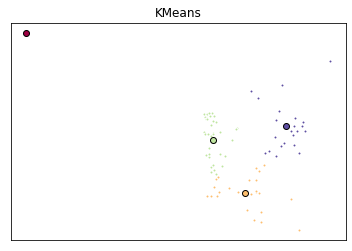

In [14]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(6, 4))

# Colors uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# For loop that plots the data points and centroids.
# k will range from 0-3, which will match the possible clusters that each
# data point is in.
for k, col in zip(range(len([[4,4], [-2, -1], [2, -3], [1, 1]])), colors):

    # Create a list of all data points, where the data points that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # Plots the datapoints with color col.
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.')
    
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)

# Title of the plot
ax.set_title('KMeans')

# Remove x-axis ticks
ax.set_xticks(())

# Remove y-axis ticks
ax.set_yticks(())

# Show the plot
plt.show()

In [15]:
k_means = KMeans(init = "k-means++", n_clusters = 3, n_init = 12)

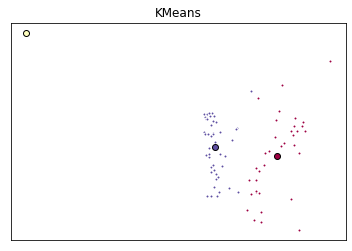

In [16]:
k_means.fit(X)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(6, 4))

# Colors uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# For loop that plots the data points and centroids.
# k will range from 0-3, which will match the possible clusters that each
# data point is in.
for k, col in zip(range(len([[4,4], [-2, -1], [2, -3], [1, 1]])), colors):

    # Create a list of all data points, where the data points that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # Plots the datapoints with color col.
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.')
    
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)

# Title of the plot
ax.set_title('KMeans')

# Remove x-axis ticks
ax.set_xticks(())

# Remove y-axis ticks
ax.set_yticks(())

# Show the plot
plt.show()

In [17]:
k_means_cluster_centers

array([[-43.53041492, 172.63656006],
       [-43.53692204, 172.63936299],
       [-43.53201831, 172.63674791]])

In [18]:
#Thus plotting this into the map of Christchurch:
for lat, lng, in zip(k_means_cluster_centers[0], k_means_cluster_centers[1]):
    folium.CircleMarker(
        [lat, lng],
        radius=50,
        popup=label,
        color='red',
        fill=True,
        fill_color='',
        fill_opacity=1,
        parse_html=False).add_to(map_cc)  
map_cc